In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
from pyomo.environ import *
from pyomo.dae import *

     |████████████████████████████████| 9.6 MB 6.7 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 


In [2]:
# incorporating time into the optimization model
import json
import math

with open('primitives.json') as f:
    items = json.load(f)


# generate the points
def generate_primitive (item) :
    geo = []
    ar_max = 1 # acceleration r
    av_max = 1 # acceleration v
    phi_max = 0.7854 # approximately Pi/4
    v_max  = 2 # max speed
    v_min = 0 # min speed
    L = 0.5 # length of the car
    alpha = 0.1 # parameter in integral for tf
    m = ConcreteModel()
    m.tf = Var(bounds=(0, 10))
    m.t = ContinuousSet(bounds=(0, 1))
    m.av = Var(m.t)
    m.phi = Var(m.t, bounds=(-phi_max, phi_max))
    m.x = Var(m.t)
    m.y = Var(m.t)
    m.theta = Var(m.t)
    m.v = Var(m.t)
    # derivatives
    m.x_dot = DerivativeVar(m.x)
    m.y_dot = DerivativeVar(m.y)
    m.theta_dot = DerivativeVar(m.theta)
    m.v_dot = DerivativeVar(m.v)
    # differential equations
    m.ode_x = Constraint(m.t, rule=lambda m, t: m.x_dot[t] == m.v[t]*cos(m.theta[t]))
    m.ode_y = Constraint(m.t, rule=lambda m, t: m.y_dot[t] == m.v[t]*sin(m.theta[t]))
    m.ode_theta = Constraint(m.t, rule=lambda m, t: m.theta_dot[t] == m.v[t]*tan(m.phi[t])/L)
    m.ode_v = Constraint(m.t, rule=lambda m, t: m.v_dot[t] == m.av[t])
    # path constaints
    m.path_v1 = Constraint(m.t, rule=lambda m, t: m.v[t] <= m.tf*v_max/L)
    m.path_v2 = Constraint(m.t, rule=lambda m, t: m.v[t] >= m.tf*v_min/L)
    m.path_a1 = Constraint(m.t, rule=lambda m, t: m.av[t] <= m.tf**2*av_max/L)
    m.path_a2 = Constraint(m.t, rule=lambda m, t: m.av[t] >= -m.tf**2*av_max/L)
    m.path_a3 = Constraint(m.t, rule=lambda m, t: m.v[t]**2*sin(m.phi[t]) <= m.tf**2*ar_max/L)
    m.path_a4 = Constraint(m.t, rule=lambda m, t: m.v[t]**2*sin(m.phi[t]) >= -m.tf**2*ar_max/L)
    # initial conditions
    m.pc = ConstraintList()
    m.pc.add(m.x[0]==0)
    m.pc.add(m.y[0]==0)
    m.pc.add(m.theta[0]==0)
    m.pc.add(m.v[0]==0)
    # final conditions
    m.pc.add(m.x[1] == item['x'])
    m.pc.add(m.y[1] == item['y'])
    m.pc.add(m.theta[1] == item['theta'])
    m.pc.add(m.v[1]==0)
    # final conditions on the control inputs
    m.pc.add(m.av[1]==0)
    m.pc.add(m.phi[1]==0)  
    # optimization objective
    m.integral = Integral(m.t, wrt=m.t, rule=lambda m, t: m.av[t]**2 + (m.v[t]**2*sin(m.phi[t]))**2)
    m.obj = Objective(expr= m.tf*alpha + L**2*m.integral/m.tf**3)
    TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=30)
    SolverFactory("ipopt").solve(m).write()
    geo1 = {}
    geo1['x'] = 0.0
    geo1['y'] = 0.0
    geo1['theta'] = 0.0
    geo1['optimized_time'] = m.tf()
    geo.append(geo1)
    # access the results
    t = np.array([t for t in m.t])
    x = np.array([m.x[t]() for t in m.t])
    y = np.array([m.y[t]() for t in m.t])
    theta = np.array([m.theta[t]() for t in m.t])
    count = 0
    for t in m.t:
        if (count != 0):
          geo2 = {}
          geo2['dx'] = m.x[t]()
          geo2['dy'] = m.y[t]()
          geo2 ['dtheta'] = m.theta[t]()
          geo.append (geo2)
        count += 1
    return geo

In [3]:
def store_result_in_json1 (item):
  geo = generate_primitive(item)   
  el = {}
  el['dx'] = item ['x']
  el['dy'] = item ['y']
  el['dtheta'] = item ['theta']
  el['weight'] = 0.0
  el['optimized_time'] = geo[0]['optimized_time']
  temp = []
  geo1 = {}
  geo1['x'] = 0.0
  geo1['y'] = 0.0
  geo1['theta'] = 0.0
  temp.append(geo1)
  for i in range (1,len(geo)): 
    geo2 = {}
    geo2['x'] = geo[i]['dx']
    geo2['y'] = geo[i]['dy']
    geo2['theta'] = geo[i]['dtheta']
    temp.append(geo2)
  el['geometry'] = temp
  return el

In [4]:
final_result = []
for i in range(0,len(items)):
  result = store_result_in_json1(items[i])
  final_result.append(result)
with open("out.json", "w") as write_file:
  json.dump(final_result, write_file, indent=4)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 440
  Number of variables: 311
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.6709723472595215
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 440
  Number of variables: 311
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.6807582378387451
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
# ==

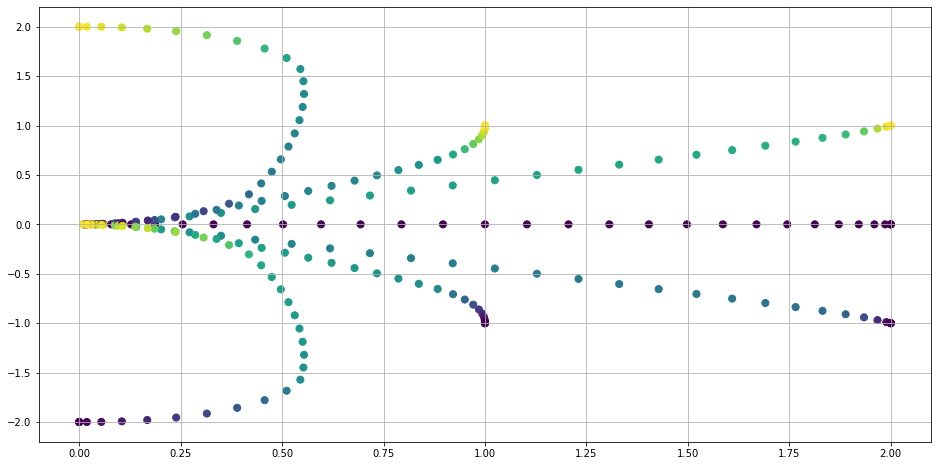

In [5]:
plt.figure(figsize=(16, 8))
t = min(10, len(items))
for i in range (0, t):
  result = generate_primitive(items[i])
  plt.scatter([p['dx'] for p in result[1:]], [p['dy'] for p in result[1:]], s=50, c=[p['dtheta'] for p in result[1:]])
  # plt.colorbar()
  plt.grid()